## Warnings [Not Sure]

tf.Data 를 활용하여 Gan에서 Epoch Batch 편하게 설정

* 맞게 했는지는 모르겠음
* 1. sess.run 할 때 마다 같은 데이터를 보는 것이 아니라 서로 다른 batch가 들어갈 것 같음. 


In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler


iris = datasets.load_iris()

In [2]:
data = iris.data



def sample_data(n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

len(data)

150

In [3]:
feature = iris.feature_names

In [4]:
input_dim = np.shape(data)[1]
latet_dim = 3
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,input_dim , activation = tf.nn.sigmoid)  # activation=None 
    return out


def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1) # activation=None

    return out, h3

In [5]:

X = tf.placeholder(tf.float32,[None,input_dim ])
Z = tf.placeholder(tf.float32,[None,latet_dim ])

In [6]:
EPOCHS = 2000
BATCH_SIZE = 50
data_len = np.shape(data)[0]
batch_iter = int(data_len / BATCH_SIZE)


batch_size = tf.placeholder(tf.int64)
## Repat 가 딱 epoch 만큼 하는 게 맞지만 gan에서는 아닌 것 같다.
dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size).repeat().shuffle(1000)
iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

print(batch_iter)

3


In [7]:
G_sample = generator(z)
r_logits, r_rep = discriminator(x)
f_logits, g_rep = discriminator(G_sample,reuse=True)

In [8]:
disc_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 
    tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))

gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


In [9]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


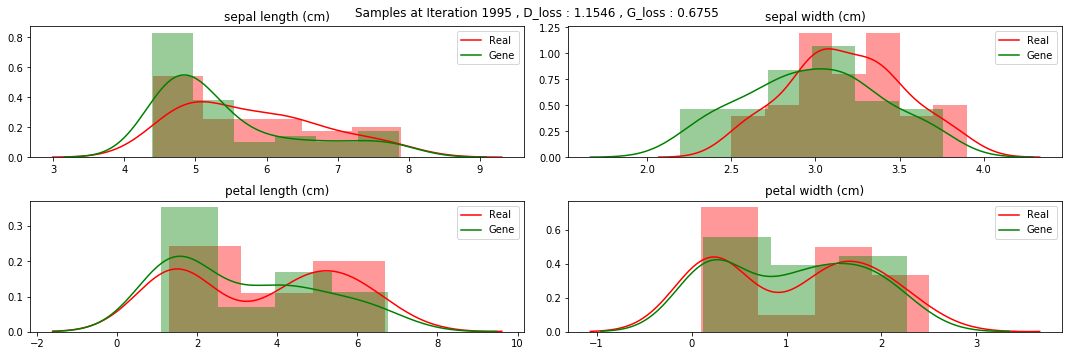

In [10]:
from IPython.display import clear_output

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)
nd_steps = 5
ng_steps = 1


def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])


x_plot = sample_data(n=BATCH_SIZE)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


#z_batch = sample_Z(data_len , latet_dim )
#sess.run(iter.initializer, feed_dict={ X : data , Z : z_batch  , batch_size: BATCH_SIZE})
for i in range(EPOCHS) : 
    z_batch = sample_Z(data_len , latet_dim )
    sess.run(iter.initializer, feed_dict={ X : data , Z : z_batch  , batch_size: BATCH_SIZE})
    for _ in range( batch_iter)  :
        
        #_, dloss , _, gloss = sess.run([disc_step, disc_loss , gen_step, gen_loss])
        
        for _ in range(nd_steps):
            _, dloss  = sess.run([disc_step, disc_loss])
        
        #rrep_dstep, grep_dstep = sess.run([r_rep, g_rep])
        
        for _ in range(ng_steps):
            _, gloss = sess.run([gen_step, gen_loss])
        
        #rrep_gstep, grep_gstep = sess.run([r_rep, g_rep])
        
        
    if i% 5 == 0 :
        clear_output(wait= True)
        fig = plt.figure(figsize = (15,5))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
        ax1.title.set_text(feature[0])
        ax2.title.set_text(feature[1])
        ax3.title.set_text(feature[2])
        ax4.title.set_text(feature[3])
        
        g_plot = sess.run(G_sample)
        g_plot = scaler.inverse_transform(g_plot)
        sns.distplot(x_plot[:,0], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax1)
        sns.distplot(g_plot[:,0], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax1)
        sns.distplot(x_plot[:,1], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax2)
        sns.distplot(g_plot[:,1], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax2)
        sns.distplot(x_plot[:,2], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax3)
        sns.distplot(g_plot[:,2], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax3)
        sns.distplot(x_plot[:,3], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax4)
        sns.distplot(g_plot[:,3], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax4)
        

#         xax = sns.distplot(x_plot, kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"})
#         gax = sns.distplot(g_plot, kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"})

        #plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.suptitle('Samples at Iteration %d , D_loss : %.4f , G_loss : %.4f'%(i,dloss,gloss) )
        plt.tight_layout()
        #plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.show()
    
        
    



In [11]:


batch_size = 45



x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size , input_dim )

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    #print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i% 100 == 0:
        fig = plt.figure(figsize = (15,5))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
        ax1.title.set_text(feature[0])
        ax2.title.set_text(feature[1])
        ax3.title.set_text(feature[2])
        ax4.title.set_text(feature[3])
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        sns.distplot(x_plot[:,0], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax1)
        sns.distplot(g_plot[:,0], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax1)
        sns.distplot(x_plot[:,1], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax2)
        sns.distplot(g_plot[:,1], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax2)
        sns.distplot(x_plot[:,2], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax3)
        sns.distplot(g_plot[:,2], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax3)
        sns.distplot(x_plot[:,3], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax4)
        sns.distplot(g_plot[:,3], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax4)
        

#         xax = sns.distplot(x_plot, kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"})
#         gax = sns.distplot(g_plot, kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"})

        #plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.suptitle('Samples at Iteration %d , D_loss : %.4f , G_loss : %.4f'%(i,dloss,gloss) )
        plt.tight_layout()
        #plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.show()

#         plt.figure()
#         rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
#         rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
#         grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
#         grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


#         plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))
#         plt.title('Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         #plt.savefig('../plots/features/feature_transform_%d.png'%i)
#         plt.show()

#         plt.figure()

#         rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
#         rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
#         grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
#         grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

#         plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))

#         plt.title('Centroid of Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         #plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
#         plt.show()

f.close()

ValueError: Cannot feed value of shape (45, 4) for Tensor 'Placeholder_1:0', which has shape '(?, 3)'

* 아주 쉬운 것도 Iteration이 2000 이상은 되야 잘 나온다.
* iris columns 하나밖에 안했을 때 학습이 잘 안되었다.
* 여러개를 하니 분포를 잘 학습하는 것을 알 수 있다. 
* 여기선 신기하게도 Scaling 안해줘도 아주아주 잘된다 
* 일단 numeric data 에 대해서는 잘 되는 것을 확인함.